# Optimizing the parameters of a ball-and-stick model

This notebook is under a LGPLv3 license.

In [5]:
import os
os.unsetenv('PYTHONHOME') # Solve an issue with NEURON simulator import

%matplotlib inline
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload

In [10]:
import bluepyopt
import bluepyopt.ephys as ephys

In [11]:
# Adding a Morphology
morph_swc_string = """
1 1 0.0 0.0 -10.0 10.0 -1                                                        
2 1 0.0 0.0 0.0 10.0 1                                                           
3 1 0.0 0.0 10.0 10.0 2                                                          
4 3 0.0 10.0 0.0 2.0 2                                                           
5 3 0.0 110.0 0.0 2.0 4
"""
with open('ballandstick.swc', 'w') as swc_file:
    swc_file.write(morph_swc_string)

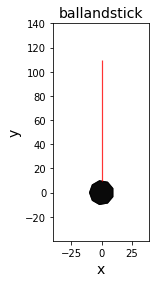

In [12]:
import neurom
import neurom.viewer
fig, ax = neurom.viewer.draw(neurom.load_neuron('ballandstick.swc'))

In [13]:
# Adding the morphology
morph = bluepyopt.ephys.morphologies.NrnFileMorphology('ballandstick.swc')

In [14]:
# Creating location objects
somatic_loc = ephys.locations.NrnSeclistLocation('somatic', seclist_name='somatic')
dend_loc = ephys.locations.NrnSeclistLocation('basal', seclist_name='basal')

In [15]:
# Creating an HH mechanism and adding it to locations
hh_mech = ephys.mechanisms.NrnMODMechanism(
        name='hh',
        suffix='hh',
        locations=[somatic_loc, dend_loc])

Let's define first a parameter that sets the specific capacitance of soma and dendrites to a frozen value. In this tutorial we'll focus on optimizing the parameters the soma. So we also fix the leakage conductance of the dendrite, and we make it passive by disabling the Na and K conductances.

In [16]:
# Creating parameters
cm = ephys.parameters.NrnSectionParameter(
        name='cm',
        param_name='cm',
        value=1.0, # in microfarad/cm2
        locations=[somatic_loc, dend_loc],
        frozen=True)


# Fix leak conductance dendrite
gl_dend = ephys.parameters.NrnSectionParameter(
        name='gl_dend',
        param_name='gl_hh',
        value=1e-5,
        locations=[dend_loc],
        frozen=True)

# Disable Na and K
gnabar_dend = ephys.parameters.NrnSectionParameter(                                    
        name='gnabar_hh_dend',
        param_name='gnabar_hh',
        locations=[dend_loc],
        value=0,
        frozen=True)   

gkbar_dend = ephys.parameters.NrnSectionParameter(
        name='gkbar_hh_dend',
        param_name='gkbar_hh',
        value=0,
        locations=[dend_loc],
        frozen=True)



In [17]:
# set the bounds for the maximal conductances of the sodium and potassium channels in the soma
gnabar_soma = ephys.parameters.NrnSectionParameter(                                    
        name='gnabar_soma',
        param_name='gnabar_hh',
        locations=[somatic_loc],
        bounds=[0.0, 1.0],
        frozen=False)     
gkbar_soma = ephys.parameters.NrnSectionParameter(
        name='gkbar_soma',
        param_name='gkbar_hh',
        bounds=[0.0, 1.0],
        locations=[somatic_loc],
        frozen=False)

In [18]:
# Creating the cel model
# Put all components together
ballandstick_cell = ephys.models.CellModel(
        name='simple_cell',
        morph=morph,
        mechs=[hh_mech],
        params=[cm, gnabar_dend, gkbar_dend, gl_dend, gnabar_soma, gkbar_soma])

In [19]:
# Print neuron description
print(ballandstick_cell)

simple_cell:
  morphology:
    ballandstick.swc
  mechanisms:
    hh: hh at ['somatic', 'basal']
  params:
    cm: ['somatic', 'basal'] cm = 1.0
    gnabar_hh_dend: ['basal'] gnabar_hh = 0
    gkbar_hh_dend: ['basal'] gkbar_hh = 0
    gl_dend: ['basal'] gl_hh = 1e-05
    gnabar_soma: ['somatic'] gnabar_hh = [0.0, 1.0]
    gkbar_soma: ['somatic'] gkbar_hh = [0.0, 1.0]



In [20]:
# Injection location
soma_loc = ephys.locations.NrnSeclistCompLocation(
        name='soma',
        seclist_name='somatic',
        sec_index=0,
        comp_x=0.5)

In [21]:
# Creating protocols
sweep_protocols = []
for protocol_name, amplitude in [('step1', 0.1), ('step2', 0.5)]:
    stim = ephys.stimuli.NrnSquarePulse(
                step_amplitude=amplitude,
                step_delay=100,
                step_duration=50,
                location=soma_loc,
                total_duration=200)
    rec = ephys.recordings.CompRecording(
            name='%s.soma.v' % protocol_name,
            location=soma_loc,
            variable='v')
    protocol = ephys.protocols.SweepProtocol(protocol_name, [stim], [rec])
    sweep_protocols.append(protocol)
twostep_protocol = ephys.protocols.SequenceProtocol('twostep', protocols=sweep_protocols)

In [23]:
# Creating simulator object
nrn = ephys.simulators.NrnSimulator()

In [24]:
default_params = {'gnabar_soma': 0.25, 'gkbar_soma': 0.1}

responses = twostep_protocol.run(cell_model=ballandstick_cell, param_values=default_params, sim=nrn)

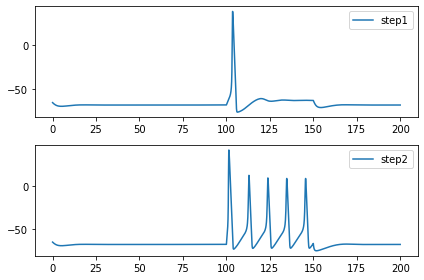

In [25]:
# Plotting the responses
def plot_responses(responses):
    plt.subplot(2,1,1)
    plt.plot(responses['step1.soma.v']['time'], responses['step1.soma.v']['voltage'], label='step1')
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(responses['step2.soma.v']['time'], responses['step2.soma.v']['voltage'], label='step2')
    plt.legend()
    plt.tight_layout()

plot_responses(responses)

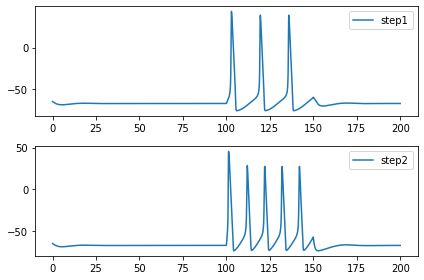

In [29]:
# Checking other parameter values
other_params = {'gnabar_soma': 0.4, 'gkbar_soma': 0.1}
plot_responses(twostep_protocol.run(cell_model=ballandstick_cell, param_values=other_params, sim=nrn))

Number of spikes in 2nd trace: [5]
Spike widths (ms) in 2nd trace: [1.7 1.2 1.1 1.1 1.1]
Spike amplitude (mV) in 2nd trace: [106.89107585  60.48828771  56.77928406  56.66706529  55.78846843]


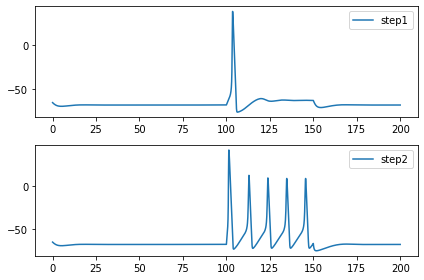

In [31]:
# Using eFEL fo extracting features from responses
responses = twostep_protocol.run(cell_model=ballandstick_cell, param_values=default_params, sim=nrn)
# show where these names come from
step2_time = responses['step2.soma.v']['time']
step2_voltage = responses['step2.soma.v']['voltage']

# Define this dictionary
trace = {'T': step2_time, 'V': step2_voltage, 'stim_start': [100], 'stim_end': [150]}

import efel
# Explain AP_width (from where to where is AP_amplitude...
feature_values = efel.getFeatureValues([trace], ['Spikecount', 'AP_width', 'AP_amplitude'])[0]

plot_responses(responses)
print('Number of spikes in 2nd trace: %s' % feature_values['Spikecount'])
print('Spike widths (ms) in 2nd trace: %s' % feature_values['AP_width'])
print('Spike amplitude (mV) in 2nd trace: %s' % feature_values['AP_amplitude'])

In [32]:
# Set a goal for optimizaton
efel_feature_means = {'step1': {'Spikecount': 4}, 'step2': {'Spikecount': 6}}

In [33]:
# Define the eFELFeature and Objective objects
objectives = []
features = []

for protocol in sweep_protocols:
    stim_start = protocol.stimuli[0].step_delay
    stim_end = stim_start + protocol.stimuli[0].step_duration
    for efel_feature_name, mean in efel_feature_means[protocol.name].items():
        feature_name = '%s.%s' % (protocol.name, efel_feature_name)
        feature = ephys.efeatures.eFELFeature(
                    feature_name,
                    efel_feature_name=efel_feature_name,
                    recording_names={'': '%s.soma.v' % protocol.name},
                    stim_start=stim_start,
                    stim_end=stim_end,
                    exp_mean=mean,
                    exp_std=0.05 * abs(mean))
        features.append(feature)
        objective = ephys.objectives.SingletonObjective(
            feature_name,
            feature)
        objectives.append(objective)

In [35]:
# Calculating scores from protocol responses
score_calc = ephys.objectivescalculators.ObjectivesCalculator(objectives) 

In [36]:
# Creating the cell evaluator
cell_evaluator = ephys.evaluators.CellEvaluator(
        cell_model=ballandstick_cell,
        param_names=['gnabar_soma', 'gkbar_soma'],
        fitness_protocols={twostep_protocol.name: twostep_protocol},
        fitness_calculator=score_calc,
        sim=nrn)

In [38]:
# Evaluating the initial parameters
print('Scores:', cell_evaluator.evaluate_with_dicts(default_params))

Scores: {'step1.Spikecount': 15.0, 'step2.Spikecount': 3.333333333333333}


In [40]:
# Set up the optimization algorithm (Evolutionary optimization)
optimisation_algorithm = bluepyopt.deapext.optimisations.IBEADEAPOptimisation(
        evaluator=cell_evaluator,
        offspring_size = 10)

In [41]:
# Running the optimization
final_pop, hall_of_fame, logs, hist = optimisation_algorithm.run(max_ngen=10)

In [43]:
# Print the results
print('Hall of fame: ')
for ind in hall_of_fame:
    print('gnabar_soma=%f, gkbar_soma=%f' % tuple(ind))

Hall of fame: 
gnabar_soma=0.111973, gkbar_soma=0.028347
gnabar_soma=0.126539, gkbar_soma=0.028130
gnabar_soma=0.126539, gkbar_soma=0.028347
gnabar_soma=0.155147, gkbar_soma=0.028347
gnabar_soma=0.769901, gkbar_soma=0.133438
gnabar_soma=0.729154, gkbar_soma=0.133678
gnabar_soma=0.768255, gkbar_soma=0.133438
gnabar_soma=0.729154, gkbar_soma=0.133438
gnabar_soma=0.564005, gkbar_soma=0.137345
gnabar_soma=0.510401, gkbar_soma=0.127938


The best individual found during the optimisation is the first individual of the hall of fame

In [45]:
# Checking the best individual
best_ind = hall_of_fame[0]
print('Best individual:  ', best_ind)

Best individual:   [0.11197318623454744, 0.02834747652200631]


In [46]:
# Evaluating the best individual
best_ind_dict = cell_evaluator.param_dict(best_ind)
print(best_ind_dict)

{'gnabar_soma': 0.11197318623454744, 'gkbar_soma': 0.02834747652200631}


Score:  {'step1.Spikecount': 0.0, 'step2.Spikecount': 0.0}


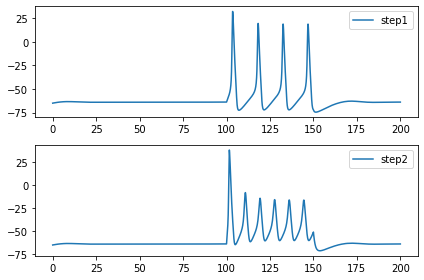

In [48]:
# Plot the responses
responses = twostep_protocol.run(cell_model=ballandstick_cell, param_values=best_ind_dict, sim=nrn)
print("Score: ", score_calc.calculate_scores(responses))
plot_responses(responses)
 

(0.0, 14.666666666666666)

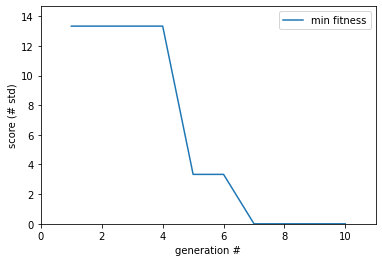

In [49]:
# Plot the fitnesses
import numpy
gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')
plt.plot(gen_numbers, min_fitness, label='min fitness')
plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness)) 

In [ ]:
# Repeating the work for AP widths of 1.3 and 1.6 for steps 1 and 2
efel_feature_means_ex = {'step1': {'AP_width': 1.3}, 'step2': {'AP_width': 1.6}}
objectives_ex = []
features_ex = []

for protocol in sweep_protocols:
    stim_start = protocol.stimuli[0].step_delay
    stim_end = stim_start + protocol.stimuli[0].step_duration
    for efel_feature_name, mean in efel_feature_means_ex[protocol.name].items():
        feature_name = '%s.%s' % (protocol.name, efel_feature_name)
        feature = ephys.efeatures.eFELFeature(
                    feature_name,
                    efel_feature_name=efel_feature_name,
                    recording_names={'': '%s.soma.v' % protocol.name},
                    stim_start=stim_start,
                    stim_end=stim_end,
                    exp_mean=mean,
                    exp_std=0.05 * abs(mean))
        features_ex.append(feature)
        objective = ephys.objectives.SingletonObjective(
            feature_name,
            feature)
        objectives_ex.append(objective)
        
score_calc_ex = ephys.objectivescalculators.ObjectivesCalculator(objectives_ex)

cell_evaluator_ex = ephys.evaluators.CellEvaluator(
        cell_model=ballandstick_cell,
        param_names=['gnabar_soma', 'gkbar_soma'],
        fitness_protocols={twostep_protocol.name: twostep_protocol},
        fitness_calculator=score_calc_ex,
        sim=nrn)

optimisation_algorithm_ex = bluepyopt.deapext.optimisations.IBEADEAPOptimisation(
        evaluator=cell_evaluator_ex,
        offspring_size = 10)

final_pop_ex, hall_of_fame_ex, logs_ex, hist_ex = optimisation_algorithm_ex.run(max_ngen=10)

best_ind_ex = hall_of_fame_ex[0]
print('Best individual: ', best_ind_ex)

best_ind_dict_ex = cell_evaluator.param_dict(best_ind_ex)
print(cell_evaluator_ex.evaluate_with_lists(best_ind_ex))

plot_responses(twostep_protocol.run(cell_model=ballandstick_cell, param_values=best_ind_dict_ex, sim=nrn))